In [ ]:
!pip -qq install spacy
!python -m spacy download en
!pip install sacremoses
!pip install subword_nmt
!wget -qq http://www.manythings.org/anki/rus-eng.zip
!unzip rus-eng.zip

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Archive:  rus-eng.zip
  inflating: rus.txt                 
  inflating: _about.txt              


In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    DEVICE = torch.device('cuda')
else:
    from torch import FloatTensor, LongTensor
    DEVICE = torch.device('cpu')

np.random.seed(42)

# Attention (5 баллов)
Ваша цель - запустить сеть хоть как-то переводить тексты. Потребуется заполнить пропуски и исправить баги. Можно менять интерфейсы функций и переписывать какие-то части. Главное, чтобы в итоговом решении был самописный encoder-decoder с attention.

Для решения задачи машинного перевода используются Seq2Seq модели, состоящие из Encoder, кодирующего входную последовательность, и Decoder, генерирующего результат.
![](https://raw.githubusercontent.com/tensorflow/nmt/master/nmt/g3doc/img/seq2seq.jpg)  
*From [tensorflow/nmt](https://github.com/tensorflow/nmt)*

Основной недостаток Seq2Seq - вся информация об исходном тексте кодируется в единственный вектор фиксированного размера. Очевидно же, что идея эта так себе.

Давайте запоминать все скрытые состояния энкодера, а не только последнее.

Дальше, для вычисления нового слова при генерации найдем сначала представление уже сгенерированного контекста (по которому обычно и генерируется следующее слово).  
По этому представлению посчитаем оценки полезности состояний энкодера: `attention weights` на картинке ниже. Чем выше вес - тем более полезно состояние. (Можно, кстати, представлять, что в предыдущем варианте мы просто давали всем состояниям кроме последнего вес 0, а последнему - 1).

С этими весами состояния энкодера суммируются, и мы получаем взвешенный вектор-представление контекста. Опять вектор?! Но теперь этот вектор получен для конкретного генерируемого слова - это же гораздо лучше, чем пытаться сделать один вектор сразу для всех генерируемых слов.

![attention](https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg)  
From [Neural Machine Translation (seq2seq) Tutorial](https://www.tensorflow.org/tutorials/seq2seq).

Более наглядно это может быть в [динамике](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/attention_mechanism.gif) (из cs224n + shad nlp course).

В результате получаются такие красивые картинки с визуализацией аттеншена:   
![att-vis](https://www.tensorflow.org/images/seq2seq/attention_vis.jpg)

Яркость ячейки показывает насколько много внимания уделяла модель данному слову на исходном языке при генерации соответствующего ему слова.

Очень красивая статья с демонстрацией attention'а: [Attention and Augmented Recurrent Neural Networks](https://distill.pub/2016/augmented-rnns/).

## Подготовка

Возьмем корпус с данными для машинного перевода:

In [ ]:
!shuf -n 10 rus.txt

Was anybody else there?	Кто-нибудь ещё там был?	CC-BY 2.0 (France) Attribution: tatoeba.org #2092628 (CK) & #2437951 (marafon)
What did you want me to do?	Что вы хотели, чтобы я сделал?	CC-BY 2.0 (France) Attribution: tatoeba.org #1886776 (CK) & #5677492 (marafon)
It's like shooting fish in a barrel.	Это проще пареной репы.	CC-BY 2.0 (France) Attribution: tatoeba.org #2006409 (CK) & #3519435 (marafon)
I regret that decision.	Я жалею об этом решении.	CC-BY 2.0 (France) Attribution: tatoeba.org #2392566 (CK) & #11526034 (marafon)
That should buy us some time.	Этим мы выиграем немного времени.	CC-BY 2.0 (France) Attribution: tatoeba.org #1107822 (Scott) & #1569022 (Biga)
Tom is sure that it was an accident.	Том уверен, что это был несчастный случай.	CC-BY 2.0 (France) Attribution: tatoeba.org #6529149 (CK) & #6922854 (marafon)
Go alone if you like.	Поезжай одна, если хочешь.	CC-BY 2.0 (France) Attribution: tatoeba.org #9271481 (CK) & #11292704 (marafon)
Such a thing has never happened bef

Токенизируем их:

In [ ]:
# !pip install -U torchtext==0.18.0


In [ ]:
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import numericalize_tokens_from_iterator
from torch.nn.utils.rnn import pad_sequence

VOCAB_SIZE = 5000
BOS_TOKEN = '<s>'
EOS_TOKEN = '</s>'

def tokenize(text, tokenizer_name, lang):
    tokenizer = get_tokenizer(tokenizer_name, lang)
    for sent in text:
        tokens = [BOS_TOKEN] + list(map(lambda x: x.lower(), tokenizer(sent))) + [EOS_TOKEN]
        yield tokens


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchtext/utils.py:4: UserWa

In [ ]:
from tqdm import tqdm

MAX_TOKENS_COUNT = 16
SUBSET_SIZE = .3

source_texts, target_texts = [], []
with open('rus.txt') as f:
    for line in tqdm(f):
        source_text, target_text = line.split('\t')[:2]
        if len(source_text) <= MAX_TOKENS_COUNT and len(target_text) <= MAX_TOKENS_COUNT:
            source_texts.append(source_text)
            target_texts.append(target_text)

source_vocab = build_vocab_from_iterator(
    tokenize(source_texts, "spacy", "en"), specials=["<UNK>"],max_tokens=VOCAB_SIZE
)
target_vocab = build_vocab_from_iterator(
    tokenize(target_texts, "moses", "ru"), specials=["<UNK>"], max_tokens=VOCAB_SIZE)

source_vocab.set_default_index(source_vocab["<UNK>"])
target_vocab.set_default_index(target_vocab["<UNK>"])

496059it [00:00, 719043.05it/s]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [ ]:
target_vocab.get_itos()[:12]

['<UNK>', '</s>', '<s>', '.', 'я', '?', 'том', 'это', 'не', 'ты', 'мы', '!']

**Задание.**

Используя полученные словари, постройте датасеты и [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) для подачи в нейросеть. Сделайте train-test-split 80/20.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class TranslationDataset(Dataset):
    def __init__(self, source_texts, target_texts, source_vocab, target_vocab, tokenizer_name_source, tokenizer_name_target):
        self.source_texts = source_texts
        self.target_texts = target_texts
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab
        self.tokenizer_source = get_tokenizer(tokenizer_name_source, "en")
        self.tokenizer_target = get_tokenizer(tokenizer_name_target, "ru")

    def __len__(self):
        return len(self.source_texts)

    def __getitem__(self, idx):
        source_text = self.source_texts[idx]
        target_text = self.target_texts[idx]

        source_tokens = [BOS_TOKEN] + [token.lower() for token in self.tokenizer_source(source_text)] + [EOS_TOKEN]
        target_tokens = [BOS_TOKEN] + [token.lower() for token in self.tokenizer_target(target_text)] + [EOS_TOKEN]

        source_indices = torch.tensor([self.source_vocab[token] for token in source_tokens])
        target_indices = torch.tensor([self.target_vocab[token] for token in target_tokens])

        return source_indices, target_indices

dataset = TranslationDataset(source_texts, target_texts, source_vocab, target_vocab, "spacy", "moses")
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

BATCH_SIZE = 32
def collate_fn(batch):
    source_batch, target_batch = zip(*batch)
    source_batch = pad_sequence(source_batch, padding_value=source_vocab[BOS_TOKEN])
    target_batch = pad_sequence(target_batch, padding_value=target_vocab[BOS_TOKEN])
    return source_batch, target_batch

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


## Seq2seq модель

Простая модель выглядит так:

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, rnn_hidden_dim=256, num_layers=1, bidirectional=False):
        super().__init__()

        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._rnn = nn.GRU(input_size=emb_dim, hidden_size=rnn_hidden_dim,
                           num_layers=num_layers, bidirectional=bidirectional)

    def forward(self, inputs, hidden=None):
        """
        input: LongTensor with shape (encoder_seq_len, batch_size)
        hidden: FloatTensor with shape (1, batch_size, rnn_hidden_dim)
        """
        encoder_output, encoder_hidden = self._rnn(self._emb(inputs), hidden)
        return encoder_output, encoder_hidden

In [ ]:
# class Decoder(nn.Module):
#     def __init__(self, vocab_size, emb_dim=128, rnn_hidden_dim=256, attn_dim=128, num_layers=1):
#         super().__init__()

#         self._emb = nn.Embedding(vocab_size, emb_dim)
#         self._rnn = nn.GRU(input_size=emb_dim, hidden_size=rnn_hidden_dim, num_layers=num_layers)
#         self._out = nn.Linear(rnn_hidden_dim, vocab_size)

#     def forward(self, inputs, encoder_output, encoder_mask, hidden=None):
#         """
#         input: LongTensor with shape (decoder_seq_len, batch_size)
#         encoder_output: FloatTensor with shape (encoder_seq_len, batch_size, rnn_hidden_dim)
#         encoder_mask: ByteTensor with shape (encoder_seq_len, batch_size) (ones in positions of <pad> tokens, zeros everywhere else)
#         hidden: FloatTensor with shape (1, batch_size, rnn_hidden_dim)
#         """
#         embs = self._emb(inputs)
#         outputs = []
#         for i in range(embs.shape[0]):
#             output, hidden = self._rnn(embs[i: i+1], hidden)

#             outputs.append(output)

#         output = torch.cat(outputs)
#         return self._out(output), hidden

## Реализация attention'а

В общем случае, attention работает так: пусть у нас есть набор скрытых состояний $\mathbf{s}_1, \ldots, \mathbf{s}_m$ - представлений слов из исходного языка, полученных с помощью энкодера. И есть некоторое текущее скрытое состояние $\mathbf{h}_i$ - скажем, представление, используемое для предсказания слова на нужном нам языке.

Тогда с помощью аттеншена мы можем получить взвешенное представление контекста $\mathbf{s}_1, \ldots, \mathbf{s}_m$ - вектор $\mathbf{c}_i$:
$$
\begin{align}\begin{split}
\mathbf{c}_i &= \sum\limits_j a_{ij}\mathbf{s}_j\\
\mathbf{a}_{ij} &= \text{softmax}(f_{att}(\mathbf{h}_i, \mathbf{s}_j))
\end{split}\end{align}
$$

$f_{att}$ - функция, которая говорит, насколько хорошо $\mathbf{h}_i$ и $\mathbf{s}_j$ подходят друг другу.

Самые популярные её варианты:
- Additive attention:
$$f_{att}(\mathbf{h}_i, \mathbf{s}_j) = \mathbf{v}_a{}^\top \text{tanh}(\mathbf{W}_a\mathbf{h}_i + \mathbf{W}_b\mathbf{s}_j)$$
- Dot attention:
$$f_{att}(\mathbf{h}_i, \mathbf{s}_j) = \mathbf{h}_i^\top \mathbf{s}_j$$
- Multiplicative attention:
$$f_{att}(\mathbf{h}_i, \mathbf{s}_j) = \mathbf{h}_i^\top \mathbf{W}_a \mathbf{s}_j$$

**Задание** Реализуйте Additive attention.

In [ ]:
class AdditiveAttention(nn.Module):
    def __init__(self, query_size, key_size, hidden_dim):
        super().__init__()
        self._query_layer = nn.Linear(query_size, hidden_dim)
        self._key_layer = nn.Linear(key_size, hidden_dim)
        self._energy_layer = nn.Linear(hidden_dim, 1)

    def forward(self, query, key, value, mask):
        """
        query: FloatTensor with shape (batch_size, query_size) (h_i)
        key: FloatTensor with shape (encoder_seq_len, batch_size, key_size) (sequence of s_1, ..., s_m)
        value: FloatTensor with shape (encoder_seq_len, batch_size, key_size) (sequence of s_1, ..., s_m)
        mask: ByteTensor with shape (encoder_seq_len, batch_size) (ones in positions of <pad> tokens, zeros everywhere else)
        """
        mask = mask.bool()
        f_att = self._energy_layer(torch.tanh(self._query_layer(query) + self._key_layer(key)))
        f_att.data.masked_fill_(mask.unsqueeze(2), -float('inf'))
        weights = torch.nn.functional.softmax(f_att, 0)
        return (weights * value).sum(0), weights
        # calc f_att as a function of query, key (s_1, ..., s_m)
        # mask out pads f_att.data.masked_fill_(mask.unsqueeze(2), -float('inf')) - after softmax the masked weights would be equal to 0
        # find the context vector as a weighed sum of value (s_1, ..., s_m) with softmax-normalized f_att weights

Нужно обновить `Decoder`, чтобы он работал с attention'ом:  
![](https://image.ibb.co/fB12nq/2018-11-12-23-34-06.png)  
*From [Attention and Augmented Recurrent Neural Networks](https://distill.pub/2016/augmented-rnns/#attentional-interfaces)*

На каждом шаге rnn'ки будем использовать текущее скрытое состояние декодера, чтобы определить, какие из состояний энкодера самые интересные.

Выход attention'а (текущий контекст) будем конкатенировать к эмбеддингу слова.

**Задание** Обновите `Decoder`.

In [ ]:
class Decoder(torch.nn.Module):
    def __init__(self, vocab_size, emb_dim=128, rnn_hidden_dim=256, num_layers=1, attention=AdditiveAttention):
        super().__init__()
        self._emb = torch.nn.Embedding(vocab_size, emb_dim)
        self._rnn = torch.nn.GRU(input_size=emb_dim + rnn_hidden_dim, hidden_size=rnn_hidden_dim ,num_layers=num_layers)
        self._out = torch.nn.Linear(rnn_hidden_dim, vocab_size)
        self._attention = attention(rnn_hidden_dim, rnn_hidden_dim, rnn_hidden_dim)

    def forward(self, inputs, encoder_output, encoder_mask, hidden=None):
        embeddings = self._emb(inputs)
        outputs, attentions = [], []
        for emb in embeddings:
            context, weights = self._attention(hidden, key=encoder_output, value=encoder_output, mask=encoder_mask)
            rnn_input = torch.cat([emb.unsqueeze(0), context.unsqueeze(0)], -1)
            out, hidden = self._rnn(rnn_input, hidden)
            outputs.append(out)
            attentions.append(weights)
        return self._out(torch.cat(outputs)), hidden, weights


In [ ]:
batch = next(iter(train_loader))

Модель перевода будет просто сперва вызывать Encoder, а потом передавать его скрытое состояние декодеру в качестве начального.

In [ ]:
class TranslationModel(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, emb_dim=64, rnn_hidden_dim=128,
                 attn_dim=128, num_layers=1, bidirectional_encoder=False):

        super().__init__()

        self.encoder = Encoder(source_vocab_size, emb_dim, rnn_hidden_dim, num_layers, bidirectional_encoder)
        self.decoder = Decoder(target_vocab_size, emb_dim, rnn_hidden_dim, num_layers, AdditiveAttention)

    def forward(self, source_inputs, target_inputs):
        encoder_mask = source_inputs == 1.
        encoder_output, encoder_hidden = self.encoder(source_inputs)

        return self.decoder(target_inputs, encoder_output, encoder_mask, encoder_hidden)

In [ ]:
model = TranslationModel(source_vocab_size=len(source_vocab), target_vocab_size=len(target_vocab)).to(DEVICE)

model(batch[0].to(DEVICE), batch[1].to(DEVICE))

(tensor([[[-1.8185e-02, -8.9030e-02, -8.1936e-02,  ..., -8.8629e-03,
            1.4674e-01, -4.9514e-03],
          [ 2.5459e-03, -4.4294e-02, -4.1621e-02,  ..., -6.2940e-03,
            1.0659e-01,  9.5282e-03],
          [ 3.5103e-02, -5.4691e-02, -6.3515e-02,  ..., -1.9317e-03,
            1.3236e-01,  1.0440e-03],
          ...,
          [ 4.7642e-02, -3.8044e-02, -7.4340e-02,  ...,  1.6507e-02,
            1.1517e-01,  2.4504e-02],
          [-6.2809e-04, -5.6659e-02, -9.3806e-02,  ..., -2.0684e-02,
            1.4421e-01, -9.7115e-03],
          [ 1.6835e-01,  5.4659e-02,  1.7524e-02,  ...,  1.9381e-01,
           -1.6457e-02,  1.1178e-02]],
 
         [[ 3.4741e-01,  1.2584e-01, -1.7543e-01,  ...,  1.9938e-01,
            8.1118e-02,  4.0003e-02],
          [ 1.2772e-01,  4.3307e-03, -7.6174e-03,  ..., -6.7153e-02,
            1.3627e-01, -1.3884e-01],
          [-8.3114e-03,  3.9497e-03, -6.2664e-02,  ...,  3.9185e-02,
            1.0930e-01,  6.9736e-02],
          ...,
    

## Тренировка модели

Нужно как-то оценивать модель.

Обычно для этого используется [BLEU скор](https://en.wikipedia.org/wiki/BLEU) - что-то вроде точности угадывания n-gram из правильного (референсного) перевода.

**Задание** Реализовать функцию оценки: для батчей из `iterator` предсказать их переводы, обрезать по `</s>` и сложить правильные варианты и предсказанные в `refs` и `hyps` соответственно.

In [ ]:
# !pip install nltk==3.8.1

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

def evaluate_model(model, iterator):
    model.eval()
    refs, hyps = [], []
    bos_index = target_vocab[BOS_TOKEN]
    eos_index = target_vocab[EOS_TOKEN]
    with torch.no_grad():
        for i, batch in enumerate(iterator):

            output, hidden = model.encoder(batch[0].to(DEVICE))
            mask = batch[0].to(DEVICE) == 1.
            result = [LongTensor([bos_index]).expand(1, batch[1].to(DEVICE).shape[1])]

            for _ in range(30):
                step, hidden, _ = model.decoder(result[-1].to(DEVICE), output, mask, hidden)
                step = step.argmax(-1)
                result.append(step)

            targets = batch[1].to(DEVICE).data.cpu().numpy().T
            indices = (targets == eos_index).argmax(-1)
            indices[indices == 0] = targets.shape[1]
            refs.extend([target[:ind] for ind, target in zip(indices, targets)])

            result = torch.cat(result).data.cpu().numpy().T
            indices = (result == eos_index).argmax(-1)
            indices[indices == 0] = result.shape[1]
            hyps.extend([r[:ind] for ind, r in zip(indices, result)])
    print(refs)
    print(hyps)
    return corpus_bleu([[ref] for ref in refs], hyps) * 100

In [ ]:
evaluate_model(model, test_loader)

[array([   2,   10, 4349,    3]), array([  2,  48, 226,   3]), array([   2,    6, 1542,   69,    3]), array([  2,   6, 758,   3]), array([   2,    7, 1393,    3]), array([   2,  606, 1822,    3]), array([   2, 1961,   11]), array([  2,  15, 130, 211,   3]), array([  2, 135,  20,   3]), array([   2,    8, 1255,    3]), array([  2, 921,  11]), array([   2,   18, 1698,    3]), array([   2,    4,   17, 3237,    3]), array([  2, 555,   3]), array([  2, 300,  16,   3]), array([  2,   4, 612,  26,   3]), array([  2,   4,  43, 813,   3]), array([  2,   6,  19, 495,   3]), array([   2,    4,  169, 1159,    3]), array([  2,  10,  41, 452,   3]), array([  2,   4,   8, 328,   3]), array([   2,    4, 1612,    3]), array([   2,  234, 3856,    3]), array([   2,   15, 1567,    3]), array([   2,    9, 1209,    3]), array([  2,   9, 112,   3]), array([  2,   6,   8, 603,   3]), array([  2,  34,  26, 446,   3]), array([2, 4, 0, 3]), array([  2,   4,  16, 632,   3]), array([   2,   63, 1991,    3]), array

25.74888158268518

In [ ]:
import math
from tqdm import tqdm
tqdm.get_lock().locks = []


def do_epoch(model, criterion, data_iter, optimizer=None, name=None):
    epoch_loss = 0

    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)

    batches_count = len(data_iter)

    with torch.autograd.grad_mode.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, batch in enumerate(data_iter):
                logits, _, _ = model(batch[0].to(DEVICE), batch[1].to(DEVICE))

                target = torch.cat((batch[1].to(DEVICE)[1:], batch[1].to(DEVICE).new_ones((1, batch[1].to(DEVICE).shape[1]))))
                loss = criterion(logits.view(-1, logits.shape[-1]), target.view(-1))

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 1.)
                    optimizer.step()

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(name, loss.item(),
                                                                                         math.exp(loss.item())))

            progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(
                name, epoch_loss / batches_count, math.exp(epoch_loss / batches_count))
            )
            progress_bar.refresh()

    return epoch_loss / batches_count


def fit(model, criterion, optimizer, train_iter, epochs_count=1, val_iter=None):
    best_val_loss = None
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss = do_epoch(model, criterion, train_iter, optimizer, name_prefix + 'Train:')

        if not val_iter is None:
            val_loss = do_epoch(model, criterion, val_iter, None, name_prefix + '  Val:')
            print('\nVal BLEU = {:.2f}'.format(evaluate_model(model, val_iter)))

In [ ]:
model = TranslationModel(source_vocab_size=len(source_vocab), target_vocab_size=len(target_vocab)).to(DEVICE)

pad_idx = target_vocab["<UNK>"]

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_loader, epochs_count=13, val_iter=test_loader)

[1 / 13] Train: Loss = 3.39179, PPX = 29.72:   7%|▋         | 34/469 [00:00<00:07, 58.22it/s] 

[1 / 13]   Val: Loss = 2.02534, PPX = 7.58: 100%|██████████| 118/118 [00:01<00:00, 117.17it/s] 


[array([   2,   10, 4349,    3]), array([  2,  48, 226,   3]), array([   2,    6, 1542,   69,    3]), array([  2,   6, 758,   3]), array([   2,    7, 1393,    3]), array([   2,  606, 1822,    3]), array([   2, 1961,   11]), array([  2,  15, 130, 211,   3]), array([  2, 135,  20,   3]), array([   2,    8, 1255,    3]), array([  2, 921,  11]), array([   2,   18, 1698,    3]), array([   2,    4,   17, 3237,    3]), array([  2, 555,   3]), array([  2, 300,  16,   3]), array([  2,   4, 612,  26,   3]), array([  2,   4,  43, 813,   3]), array([  2,   6,  19, 495,   3]), array([   2,    4,  169, 1159,    3]), array([  2,  10,  41, 452,   3]), array([  2,   4,   8, 328,   3]), array([   2,    4, 1612,    3]), array([   2,  234, 3856,    3]), array([   2,   15, 1567,    3]), array([   2,    9, 1209,    3]), array([  2,   9, 112,   3]), array([  2,   6,   8, 603,   3]), array([  2,  34,  26, 446,   3]), array([2, 4, 0, 3]), array([  2,   4,  16, 632,   3]), array([   2,   63, 1991,    3]), array

[2 / 13]   Val: Loss = 1.77719, PPX = 5.91: 100%|██████████| 118/118 [00:00<00:00, 119.82it/s] 


[array([   2,   10, 4349,    3]), array([  2,  48, 226,   3]), array([   2,    6, 1542,   69,    3]), array([  2,   6, 758,   3]), array([   2,    7, 1393,    3]), array([   2,  606, 1822,    3]), array([   2, 1961,   11]), array([  2,  15, 130, 211,   3]), array([  2, 135,  20,   3]), array([   2,    8, 1255,    3]), array([  2, 921,  11]), array([   2,   18, 1698,    3]), array([   2,    4,   17, 3237,    3]), array([  2, 555,   3]), array([  2, 300,  16,   3]), array([  2,   4, 612,  26,   3]), array([  2,   4,  43, 813,   3]), array([  2,   6,  19, 495,   3]), array([   2,    4,  169, 1159,    3]), array([  2,  10,  41, 452,   3]), array([  2,   4,   8, 328,   3]), array([   2,    4, 1612,    3]), array([   2,  234, 3856,    3]), array([   2,   15, 1567,    3]), array([   2,    9, 1209,    3]), array([  2,   9, 112,   3]), array([  2,   6,   8, 603,   3]), array([  2,  34,  26, 446,   3]), array([2, 4, 0, 3]), array([  2,   4,  16, 632,   3]), array([   2,   63, 1991,    3]), array

[3 / 13]   Val: Loss = 1.62433, PPX = 5.08: 100%|██████████| 118/118 [00:01<00:00, 115.48it/s] 


[array([   2,   10, 4349,    3]), array([  2,  48, 226,   3]), array([   2,    6, 1542,   69,    3]), array([  2,   6, 758,   3]), array([   2,    7, 1393,    3]), array([   2,  606, 1822,    3]), array([   2, 1961,   11]), array([  2,  15, 130, 211,   3]), array([  2, 135,  20,   3]), array([   2,    8, 1255,    3]), array([  2, 921,  11]), array([   2,   18, 1698,    3]), array([   2,    4,   17, 3237,    3]), array([  2, 555,   3]), array([  2, 300,  16,   3]), array([  2,   4, 612,  26,   3]), array([  2,   4,  43, 813,   3]), array([  2,   6,  19, 495,   3]), array([   2,    4,  169, 1159,    3]), array([  2,  10,  41, 452,   3]), array([  2,   4,   8, 328,   3]), array([   2,    4, 1612,    3]), array([   2,  234, 3856,    3]), array([   2,   15, 1567,    3]), array([   2,    9, 1209,    3]), array([  2,   9, 112,   3]), array([  2,   6,   8, 603,   3]), array([  2,  34,  26, 446,   3]), array([2, 4, 0, 3]), array([  2,   4,  16, 632,   3]), array([   2,   63, 1991,    3]), array

[4 / 13]   Val: Loss = 1.52289, PPX = 4.59: 100%|██████████| 118/118 [00:01<00:00, 111.90it/s]


[array([   2,   10, 4349,    3]), array([  2,  48, 226,   3]), array([   2,    6, 1542,   69,    3]), array([  2,   6, 758,   3]), array([   2,    7, 1393,    3]), array([   2,  606, 1822,    3]), array([   2, 1961,   11]), array([  2,  15, 130, 211,   3]), array([  2, 135,  20,   3]), array([   2,    8, 1255,    3]), array([  2, 921,  11]), array([   2,   18, 1698,    3]), array([   2,    4,   17, 3237,    3]), array([  2, 555,   3]), array([  2, 300,  16,   3]), array([  2,   4, 612,  26,   3]), array([  2,   4,  43, 813,   3]), array([  2,   6,  19, 495,   3]), array([   2,    4,  169, 1159,    3]), array([  2,  10,  41, 452,   3]), array([  2,   4,   8, 328,   3]), array([   2,    4, 1612,    3]), array([   2,  234, 3856,    3]), array([   2,   15, 1567,    3]), array([   2,    9, 1209,    3]), array([  2,   9, 112,   3]), array([  2,   6,   8, 603,   3]), array([  2,  34,  26, 446,   3]), array([2, 4, 0, 3]), array([  2,   4,  16, 632,   3]), array([   2,   63, 1991,    3]), array

[5 / 13]   Val: Loss = 1.44905, PPX = 4.26: 100%|██████████| 118/118 [00:01<00:00, 116.73it/s]


[array([   2,   10, 4349,    3]), array([  2,  48, 226,   3]), array([   2,    6, 1542,   69,    3]), array([  2,   6, 758,   3]), array([   2,    7, 1393,    3]), array([   2,  606, 1822,    3]), array([   2, 1961,   11]), array([  2,  15, 130, 211,   3]), array([  2, 135,  20,   3]), array([   2,    8, 1255,    3]), array([  2, 921,  11]), array([   2,   18, 1698,    3]), array([   2,    4,   17, 3237,    3]), array([  2, 555,   3]), array([  2, 300,  16,   3]), array([  2,   4, 612,  26,   3]), array([  2,   4,  43, 813,   3]), array([  2,   6,  19, 495,   3]), array([   2,    4,  169, 1159,    3]), array([  2,  10,  41, 452,   3]), array([  2,   4,   8, 328,   3]), array([   2,    4, 1612,    3]), array([   2,  234, 3856,    3]), array([   2,   15, 1567,    3]), array([   2,    9, 1209,    3]), array([  2,   9, 112,   3]), array([  2,   6,   8, 603,   3]), array([  2,  34,  26, 446,   3]), array([2, 4, 0, 3]), array([  2,   4,  16, 632,   3]), array([   2,   63, 1991,    3]), array

[6 / 13]   Val: Loss = 1.35189, PPX = 3.86: 100%|██████████| 118/118 [00:00<00:00, 120.88it/s]


[array([   2,   10, 4349,    3]), array([  2,  48, 226,   3]), array([   2,    6, 1542,   69,    3]), array([  2,   6, 758,   3]), array([   2,    7, 1393,    3]), array([   2,  606, 1822,    3]), array([   2, 1961,   11]), array([  2,  15, 130, 211,   3]), array([  2, 135,  20,   3]), array([   2,    8, 1255,    3]), array([  2, 921,  11]), array([   2,   18, 1698,    3]), array([   2,    4,   17, 3237,    3]), array([  2, 555,   3]), array([  2, 300,  16,   3]), array([  2,   4, 612,  26,   3]), array([  2,   4,  43, 813,   3]), array([  2,   6,  19, 495,   3]), array([   2,    4,  169, 1159,    3]), array([  2,  10,  41, 452,   3]), array([  2,   4,   8, 328,   3]), array([   2,    4, 1612,    3]), array([   2,  234, 3856,    3]), array([   2,   15, 1567,    3]), array([   2,    9, 1209,    3]), array([  2,   9, 112,   3]), array([  2,   6,   8, 603,   3]), array([  2,  34,  26, 446,   3]), array([2, 4, 0, 3]), array([  2,   4,  16, 632,   3]), array([   2,   63, 1991,    3]), array

[7 / 13]   Val: Loss = 1.29053, PPX = 3.63: 100%|██████████| 118/118 [00:01<00:00, 117.78it/s]


[array([   2,   10, 4349,    3]), array([  2,  48, 226,   3]), array([   2,    6, 1542,   69,    3]), array([  2,   6, 758,   3]), array([   2,    7, 1393,    3]), array([   2,  606, 1822,    3]), array([   2, 1961,   11]), array([  2,  15, 130, 211,   3]), array([  2, 135,  20,   3]), array([   2,    8, 1255,    3]), array([  2, 921,  11]), array([   2,   18, 1698,    3]), array([   2,    4,   17, 3237,    3]), array([  2, 555,   3]), array([  2, 300,  16,   3]), array([  2,   4, 612,  26,   3]), array([  2,   4,  43, 813,   3]), array([  2,   6,  19, 495,   3]), array([   2,    4,  169, 1159,    3]), array([  2,  10,  41, 452,   3]), array([  2,   4,   8, 328,   3]), array([   2,    4, 1612,    3]), array([   2,  234, 3856,    3]), array([   2,   15, 1567,    3]), array([   2,    9, 1209,    3]), array([  2,   9, 112,   3]), array([  2,   6,   8, 603,   3]), array([  2,  34,  26, 446,   3]), array([2, 4, 0, 3]), array([  2,   4,  16, 632,   3]), array([   2,   63, 1991,    3]), array

[8 / 13]   Val: Loss = 1.26107, PPX = 3.53: 100%|██████████| 118/118 [00:00<00:00, 118.34it/s]


[array([   2,   10, 4349,    3]), array([  2,  48, 226,   3]), array([   2,    6, 1542,   69,    3]), array([  2,   6, 758,   3]), array([   2,    7, 1393,    3]), array([   2,  606, 1822,    3]), array([   2, 1961,   11]), array([  2,  15, 130, 211,   3]), array([  2, 135,  20,   3]), array([   2,    8, 1255,    3]), array([  2, 921,  11]), array([   2,   18, 1698,    3]), array([   2,    4,   17, 3237,    3]), array([  2, 555,   3]), array([  2, 300,  16,   3]), array([  2,   4, 612,  26,   3]), array([  2,   4,  43, 813,   3]), array([  2,   6,  19, 495,   3]), array([   2,    4,  169, 1159,    3]), array([  2,  10,  41, 452,   3]), array([  2,   4,   8, 328,   3]), array([   2,    4, 1612,    3]), array([   2,  234, 3856,    3]), array([   2,   15, 1567,    3]), array([   2,    9, 1209,    3]), array([  2,   9, 112,   3]), array([  2,   6,   8, 603,   3]), array([  2,  34,  26, 446,   3]), array([2, 4, 0, 3]), array([  2,   4,  16, 632,   3]), array([   2,   63, 1991,    3]), array

[9 / 13]   Val: Loss = 1.21500, PPX = 3.37: 100%|██████████| 118/118 [00:00<00:00, 119.20it/s]


[array([   2,   10, 4349,    3]), array([  2,  48, 226,   3]), array([   2,    6, 1542,   69,    3]), array([  2,   6, 758,   3]), array([   2,    7, 1393,    3]), array([   2,  606, 1822,    3]), array([   2, 1961,   11]), array([  2,  15, 130, 211,   3]), array([  2, 135,  20,   3]), array([   2,    8, 1255,    3]), array([  2, 921,  11]), array([   2,   18, 1698,    3]), array([   2,    4,   17, 3237,    3]), array([  2, 555,   3]), array([  2, 300,  16,   3]), array([  2,   4, 612,  26,   3]), array([  2,   4,  43, 813,   3]), array([  2,   6,  19, 495,   3]), array([   2,    4,  169, 1159,    3]), array([  2,  10,  41, 452,   3]), array([  2,   4,   8, 328,   3]), array([   2,    4, 1612,    3]), array([   2,  234, 3856,    3]), array([   2,   15, 1567,    3]), array([   2,    9, 1209,    3]), array([  2,   9, 112,   3]), array([  2,   6,   8, 603,   3]), array([  2,  34,  26, 446,   3]), array([2, 4, 0, 3]), array([  2,   4,  16, 632,   3]), array([   2,   63, 1991,    3]), array

[10 / 13]   Val: Loss = 1.21459, PPX = 3.37: 100%|██████████| 118/118 [00:01<00:00, 115.51it/s]


[array([   2,   10, 4349,    3]), array([  2,  48, 226,   3]), array([   2,    6, 1542,   69,    3]), array([  2,   6, 758,   3]), array([   2,    7, 1393,    3]), array([   2,  606, 1822,    3]), array([   2, 1961,   11]), array([  2,  15, 130, 211,   3]), array([  2, 135,  20,   3]), array([   2,    8, 1255,    3]), array([  2, 921,  11]), array([   2,   18, 1698,    3]), array([   2,    4,   17, 3237,    3]), array([  2, 555,   3]), array([  2, 300,  16,   3]), array([  2,   4, 612,  26,   3]), array([  2,   4,  43, 813,   3]), array([  2,   6,  19, 495,   3]), array([   2,    4,  169, 1159,    3]), array([  2,  10,  41, 452,   3]), array([  2,   4,   8, 328,   3]), array([   2,    4, 1612,    3]), array([   2,  234, 3856,    3]), array([   2,   15, 1567,    3]), array([   2,    9, 1209,    3]), array([  2,   9, 112,   3]), array([  2,   6,   8, 603,   3]), array([  2,  34,  26, 446,   3]), array([2, 4, 0, 3]), array([  2,   4,  16, 632,   3]), array([   2,   63, 1991,    3]), array

[11 / 13]   Val: Loss = 1.19799, PPX = 3.31: 100%|██████████| 118/118 [00:01<00:00, 110.89it/s]


[array([   2,   10, 4349,    3]), array([  2,  48, 226,   3]), array([   2,    6, 1542,   69,    3]), array([  2,   6, 758,   3]), array([   2,    7, 1393,    3]), array([   2,  606, 1822,    3]), array([   2, 1961,   11]), array([  2,  15, 130, 211,   3]), array([  2, 135,  20,   3]), array([   2,    8, 1255,    3]), array([  2, 921,  11]), array([   2,   18, 1698,    3]), array([   2,    4,   17, 3237,    3]), array([  2, 555,   3]), array([  2, 300,  16,   3]), array([  2,   4, 612,  26,   3]), array([  2,   4,  43, 813,   3]), array([  2,   6,  19, 495,   3]), array([   2,    4,  169, 1159,    3]), array([  2,  10,  41, 452,   3]), array([  2,   4,   8, 328,   3]), array([   2,    4, 1612,    3]), array([   2,  234, 3856,    3]), array([   2,   15, 1567,    3]), array([   2,    9, 1209,    3]), array([  2,   9, 112,   3]), array([  2,   6,   8, 603,   3]), array([  2,  34,  26, 446,   3]), array([2, 4, 0, 3]), array([  2,   4,  16, 632,   3]), array([   2,   63, 1991,    3]), array

[12 / 13]   Val: Loss = 1.17626, PPX = 3.24: 100%|██████████| 118/118 [00:01<00:00, 110.26it/s]


[array([   2,   10, 4349,    3]), array([  2,  48, 226,   3]), array([   2,    6, 1542,   69,    3]), array([  2,   6, 758,   3]), array([   2,    7, 1393,    3]), array([   2,  606, 1822,    3]), array([   2, 1961,   11]), array([  2,  15, 130, 211,   3]), array([  2, 135,  20,   3]), array([   2,    8, 1255,    3]), array([  2, 921,  11]), array([   2,   18, 1698,    3]), array([   2,    4,   17, 3237,    3]), array([  2, 555,   3]), array([  2, 300,  16,   3]), array([  2,   4, 612,  26,   3]), array([  2,   4,  43, 813,   3]), array([  2,   6,  19, 495,   3]), array([   2,    4,  169, 1159,    3]), array([  2,  10,  41, 452,   3]), array([  2,   4,   8, 328,   3]), array([   2,    4, 1612,    3]), array([   2,  234, 3856,    3]), array([   2,   15, 1567,    3]), array([   2,    9, 1209,    3]), array([  2,   9, 112,   3]), array([  2,   6,   8, 603,   3]), array([  2,  34,  26, 446,   3]), array([2, 4, 0, 3]), array([  2,   4,  16, 632,   3]), array([   2,   63, 1991,    3]), array

[13 / 13]   Val: Loss = 1.21548, PPX = 3.37: 100%|██████████| 118/118 [00:01<00:00, 115.46it/s]


[array([   2,   10, 4349,    3]), array([  2,  48, 226,   3]), array([   2,    6, 1542,   69,    3]), array([  2,   6, 758,   3]), array([   2,    7, 1393,    3]), array([   2,  606, 1822,    3]), array([   2, 1961,   11]), array([  2,  15, 130, 211,   3]), array([  2, 135,  20,   3]), array([   2,    8, 1255,    3]), array([  2, 921,  11]), array([   2,   18, 1698,    3]), array([   2,    4,   17, 3237,    3]), array([  2, 555,   3]), array([  2, 300,  16,   3]), array([  2,   4, 612,  26,   3]), array([  2,   4,  43, 813,   3]), array([  2,   6,  19, 495,   3]), array([   2,    4,  169, 1159,    3]), array([  2,  10,  41, 452,   3]), array([  2,   4,   8, 328,   3]), array([   2,    4, 1612,    3]), array([   2,  234, 3856,    3]), array([   2,   15, 1567,    3]), array([   2,    9, 1209,    3]), array([  2,   9, 112,   3]), array([  2,   6,   8, 603,   3]), array([  2,  34,  26, 446,   3]), array([2, 4, 0, 3]), array([  2,   4,  16, 632,   3]), array([   2,   63, 1991,    3]), array

## Визуализация результатов

In [ ]:
def greedy_decode(model, source_text):
    bos_index = target_vocab[BOS_TOKEN]
    eos_index = target_vocab[EOS_TOKEN]
    model.eval()
    with torch.no_grad():
        result, attentions = [], []
        source = [source_vocab[token] for token in source_text.split()]
        inputs = torch.tensor(source, dtype=torch.long, device=DEVICE).unsqueeze(1)
        print(inputs)
        encoder_output, encoder_hidden = model.encoder(inputs)
        encoder_mask = torch.zeros_like(inputs).byte()

        hidden = encoder_hidden
        step = LongTensor([[bos_index]])

        for _ in range(50):
            step, hidden, attention = model.decoder(step, encoder_output, encoder_mask, hidden)
            attentions.append(attention.squeeze(1))

            step = torch.argmax(step, dim=-1)
            if step.item() == eos_index:
                break

            result.append(step.item())
        print(result)
        result = [target_vocab.get_itos()[ind] for ind in result]
        return source_text.split(), result, torch.cat(attentions, -1).data.cpu().numpy()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_heatmap(src, trg, scores):

    fig, ax = plt.subplots()
    heatmap = ax.pcolor(scores, cmap='viridis')

    ax.set_xticklabels(trg, minor=False, rotation=45)
    ax.set_yticklabels(src, minor=False)

    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()

    plt.colorbar(heatmap)
    plt.show()

In [ ]:
source, result, attentions = greedy_decode(model, "i was honest")


tensor([[  4],
        [ 16],
        [532]], device='cuda:0')
[4, 17, 1006, 5]


/tmp/ipykernel_26049/1168318779.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(trg, minor=False, rotation=45)
/tmp/ipykernel_26049/1168318779.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(src, minor=False)


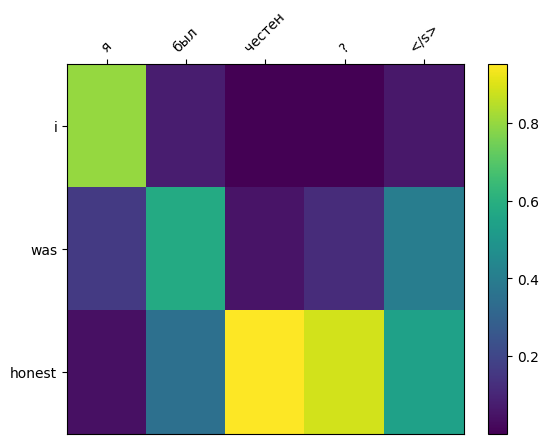

In [ ]:
plot_heatmap(source + ['</s>'], result + ['</s>'], attentions)

## Улучшение модели

**Задание** Попробуйте любой другой вариант attention'а (2 балла)

**Задание** Попробуйте улучшить архитектуру сети: предобученные эмбеддинги, bpe, dropout, bidirectional or multi-layer encoder (3 балла, по одному за любое улучшение)

Попробуем DotAttention

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DotProductAttention(nn.Module):
    def __init__(self):
        super(DotProductAttention, self).__init__()

    def forward(self, query, key, value, mask=None):
        print(query.shape, key.shape)
        scores = torch.matmul(query, key.transpose(-2, -1)) / torch.sqrt(torch.tensor(query.size(-1)).float())
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        weights = F.softmax(scores, dim=-1)
        attended_values = torch.matmul(weights, value)
        return attended_values, weights


In [ ]:
class Decoder(torch.nn.Module):
    def __init__(self, vocab_size, emb_dim=128, rnn_hidden_dim=256, num_layers=1, attention=DotProductAttention):
        super().__init__()
        self._emb = torch.nn.Embedding(vocab_size, emb_dim)
        self._rnn = torch.nn.GRU(input_size=emb_dim + rnn_hidden_dim, hidden_size=rnn_hidden_dim ,num_layers=num_layers)
        self._out = torch.nn.Linear(rnn_hidden_dim, vocab_size)
        self._attention = attention()

    def forward(self, inputs, encoder_output, encoder_mask, hidden=None):
        embeddings = self._emb(inputs)
        outputs, attentions = [], []
        for emb in embeddings:
            context, weights = self._attention(hidden, key=encoder_output, value=encoder_output, mask=encoder_mask)
            rnn_input = torch.cat([emb.unsqueeze(0), context.unsqueeze(0)], -1)
            out, hidden = self._rnn(rnn_input, hidden)
            outputs.append(out)
            attentions.append(weights)
        return self._out(torch.cat(outputs)), hidden, weights


In [ ]:
class TranslationModel(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, emb_dim=64, rnn_hidden_dim=128,
                 attn_dim=128, num_layers=1, bidirectional_encoder=False):

        super().__init__()

        self.encoder = Encoder(source_vocab_size, emb_dim, rnn_hidden_dim, num_layers, bidirectional_encoder)
        self.decoder = Decoder(target_vocab_size, emb_dim, rnn_hidden_dim, num_layers, DotProductAttention)

    def forward(self, source_inputs, target_inputs):
        encoder_mask = source_inputs == 1.
        encoder_output, encoder_hidden = self.encoder(source_inputs)

        return self.decoder(target_inputs, encoder_output, encoder_mask, encoder_hidden)

In [ ]:
newmodel = TranslationModel(source_vocab_size=len(source_vocab), target_vocab_size=len(target_vocab)).to(DEVICE)

pad_idx = target_vocab["<UNK>"]

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(newmodel.parameters())

fit(newmodel, criterion, optimizer, train_loader, epochs_count=13, val_iter=test_loader)

[1 / 13]   Val: Loss = 2.14088, PPX = 8.51: 100%|██████████| 118/118 [00:01<00:00, 117.02it/s] 


[array([   2,   10, 4349,    3]), array([  2,  48, 226,   3]), array([   2,    6, 1542,   69,    3]), array([  2,   6, 758,   3]), array([   2,    7, 1393,    3]), array([   2,  606, 1822,    3]), array([   2, 1961,   11]), array([  2,  15, 130, 211,   3]), array([  2, 135,  20,   3]), array([   2,    8, 1255,    3]), array([  2, 921,  11]), array([   2,   18, 1698,    3]), array([   2,    4,   17, 3237,    3]), array([  2, 555,   3]), array([  2, 300,  16,   3]), array([  2,   4, 612,  26,   3]), array([  2,   4,  43, 813,   3]), array([  2,   6,  19, 495,   3]), array([   2,    4,  169, 1159,    3]), array([  2,  10,  41, 452,   3]), array([  2,   4,   8, 328,   3]), array([   2,    4, 1612,    3]), array([   2,  234, 3856,    3]), array([   2,   15, 1567,    3]), array([   2,    9, 1209,    3]), array([  2,   9, 112,   3]), array([  2,   6,   8, 603,   3]), array([  2,  34,  26, 446,   3]), array([2, 4, 0, 3]), array([  2,   4,  16, 632,   3]), array([   2,   63, 1991,    3]), array

[2 / 13]   Val: Loss = 1.81311, PPX = 6.13: 100%|██████████| 118/118 [00:01<00:00, 112.58it/s] 


[array([   2,   10, 4349,    3]), array([  2,  48, 226,   3]), array([   2,    6, 1542,   69,    3]), array([  2,   6, 758,   3]), array([   2,    7, 1393,    3]), array([   2,  606, 1822,    3]), array([   2, 1961,   11]), array([  2,  15, 130, 211,   3]), array([  2, 135,  20,   3]), array([   2,    8, 1255,    3]), array([  2, 921,  11]), array([   2,   18, 1698,    3]), array([   2,    4,   17, 3237,    3]), array([  2, 555,   3]), array([  2, 300,  16,   3]), array([  2,   4, 612,  26,   3]), array([  2,   4,  43, 813,   3]), array([  2,   6,  19, 495,   3]), array([   2,    4,  169, 1159,    3]), array([  2,  10,  41, 452,   3]), array([  2,   4,   8, 328,   3]), array([   2,    4, 1612,    3]), array([   2,  234, 3856,    3]), array([   2,   15, 1567,    3]), array([   2,    9, 1209,    3]), array([  2,   9, 112,   3]), array([  2,   6,   8, 603,   3]), array([  2,  34,  26, 446,   3]), array([2, 4, 0, 3]), array([  2,   4,  16, 632,   3]), array([   2,   63, 1991,    3]), array

[3 / 13]   Val: Loss = 1.66244, PPX = 5.27: 100%|██████████| 118/118 [00:01<00:00, 114.59it/s] 


[array([   2,   10, 4349,    3]), array([  2,  48, 226,   3]), array([   2,    6, 1542,   69,    3]), array([  2,   6, 758,   3]), array([   2,    7, 1393,    3]), array([   2,  606, 1822,    3]), array([   2, 1961,   11]), array([  2,  15, 130, 211,   3]), array([  2, 135,  20,   3]), array([   2,    8, 1255,    3]), array([  2, 921,  11]), array([   2,   18, 1698,    3]), array([   2,    4,   17, 3237,    3]), array([  2, 555,   3]), array([  2, 300,  16,   3]), array([  2,   4, 612,  26,   3]), array([  2,   4,  43, 813,   3]), array([  2,   6,  19, 495,   3]), array([   2,    4,  169, 1159,    3]), array([  2,  10,  41, 452,   3]), array([  2,   4,   8, 328,   3]), array([   2,    4, 1612,    3]), array([   2,  234, 3856,    3]), array([   2,   15, 1567,    3]), array([   2,    9, 1209,    3]), array([  2,   9, 112,   3]), array([  2,   6,   8, 603,   3]), array([  2,  34,  26, 446,   3]), array([2, 4, 0, 3]), array([  2,   4,  16, 632,   3]), array([   2,   63, 1991,    3]), array

[4 / 13]   Val: Loss = 1.54535, PPX = 4.69: 100%|██████████| 118/118 [00:01<00:00, 113.72it/s] 


[array([   2,   10, 4349,    3]), array([  2,  48, 226,   3]), array([   2,    6, 1542,   69,    3]), array([  2,   6, 758,   3]), array([   2,    7, 1393,    3]), array([   2,  606, 1822,    3]), array([   2, 1961,   11]), array([  2,  15, 130, 211,   3]), array([  2, 135,  20,   3]), array([   2,    8, 1255,    3]), array([  2, 921,  11]), array([   2,   18, 1698,    3]), array([   2,    4,   17, 3237,    3]), array([  2, 555,   3]), array([  2, 300,  16,   3]), array([  2,   4, 612,  26,   3]), array([  2,   4,  43, 813,   3]), array([  2,   6,  19, 495,   3]), array([   2,    4,  169, 1159,    3]), array([  2,  10,  41, 452,   3]), array([  2,   4,   8, 328,   3]), array([   2,    4, 1612,    3]), array([   2,  234, 3856,    3]), array([   2,   15, 1567,    3]), array([   2,    9, 1209,    3]), array([  2,   9, 112,   3]), array([  2,   6,   8, 603,   3]), array([  2,  34,  26, 446,   3]), array([2, 4, 0, 3]), array([  2,   4,  16, 632,   3]), array([   2,   63, 1991,    3]), array

[5 / 13]   Val: Loss = 1.47602, PPX = 4.38: 100%|██████████| 118/118 [00:01<00:00, 114.17it/s]


[array([   2,   10, 4349,    3]), array([  2,  48, 226,   3]), array([   2,    6, 1542,   69,    3]), array([  2,   6, 758,   3]), array([   2,    7, 1393,    3]), array([   2,  606, 1822,    3]), array([   2, 1961,   11]), array([  2,  15, 130, 211,   3]), array([  2, 135,  20,   3]), array([   2,    8, 1255,    3]), array([  2, 921,  11]), array([   2,   18, 1698,    3]), array([   2,    4,   17, 3237,    3]), array([  2, 555,   3]), array([  2, 300,  16,   3]), array([  2,   4, 612,  26,   3]), array([  2,   4,  43, 813,   3]), array([  2,   6,  19, 495,   3]), array([   2,    4,  169, 1159,    3]), array([  2,  10,  41, 452,   3]), array([  2,   4,   8, 328,   3]), array([   2,    4, 1612,    3]), array([   2,  234, 3856,    3]), array([   2,   15, 1567,    3]), array([   2,    9, 1209,    3]), array([  2,   9, 112,   3]), array([  2,   6,   8, 603,   3]), array([  2,  34,  26, 446,   3]), array([2, 4, 0, 3]), array([  2,   4,  16, 632,   3]), array([   2,   63, 1991,    3]), array

[6 / 13]   Val: Loss = 1.36211, PPX = 3.90: 100%|██████████| 118/118 [00:01<00:00, 114.33it/s]


[array([   2,   10, 4349,    3]), array([  2,  48, 226,   3]), array([   2,    6, 1542,   69,    3]), array([  2,   6, 758,   3]), array([   2,    7, 1393,    3]), array([   2,  606, 1822,    3]), array([   2, 1961,   11]), array([  2,  15, 130, 211,   3]), array([  2, 135,  20,   3]), array([   2,    8, 1255,    3]), array([  2, 921,  11]), array([   2,   18, 1698,    3]), array([   2,    4,   17, 3237,    3]), array([  2, 555,   3]), array([  2, 300,  16,   3]), array([  2,   4, 612,  26,   3]), array([  2,   4,  43, 813,   3]), array([  2,   6,  19, 495,   3]), array([   2,    4,  169, 1159,    3]), array([  2,  10,  41, 452,   3]), array([  2,   4,   8, 328,   3]), array([   2,    4, 1612,    3]), array([   2,  234, 3856,    3]), array([   2,   15, 1567,    3]), array([   2,    9, 1209,    3]), array([  2,   9, 112,   3]), array([  2,   6,   8, 603,   3]), array([  2,  34,  26, 446,   3]), array([2, 4, 0, 3]), array([  2,   4,  16, 632,   3]), array([   2,   63, 1991,    3]), array

[7 / 13]   Val: Loss = 1.32468, PPX = 3.76: 100%|██████████| 118/118 [00:01<00:00, 111.14it/s]


[array([   2,   10, 4349,    3]), array([  2,  48, 226,   3]), array([   2,    6, 1542,   69,    3]), array([  2,   6, 758,   3]), array([   2,    7, 1393,    3]), array([   2,  606, 1822,    3]), array([   2, 1961,   11]), array([  2,  15, 130, 211,   3]), array([  2, 135,  20,   3]), array([   2,    8, 1255,    3]), array([  2, 921,  11]), array([   2,   18, 1698,    3]), array([   2,    4,   17, 3237,    3]), array([  2, 555,   3]), array([  2, 300,  16,   3]), array([  2,   4, 612,  26,   3]), array([  2,   4,  43, 813,   3]), array([  2,   6,  19, 495,   3]), array([   2,    4,  169, 1159,    3]), array([  2,  10,  41, 452,   3]), array([  2,   4,   8, 328,   3]), array([   2,    4, 1612,    3]), array([   2,  234, 3856,    3]), array([   2,   15, 1567,    3]), array([   2,    9, 1209,    3]), array([  2,   9, 112,   3]), array([  2,   6,   8, 603,   3]), array([  2,  34,  26, 446,   3]), array([2, 4, 0, 3]), array([  2,   4,  16, 632,   3]), array([   2,   63, 1991,    3]), array

[8 / 13]   Val: Loss = 1.28634, PPX = 3.62: 100%|██████████| 118/118 [00:01<00:00, 115.46it/s]


[array([   2,   10, 4349,    3]), array([  2,  48, 226,   3]), array([   2,    6, 1542,   69,    3]), array([  2,   6, 758,   3]), array([   2,    7, 1393,    3]), array([   2,  606, 1822,    3]), array([   2, 1961,   11]), array([  2,  15, 130, 211,   3]), array([  2, 135,  20,   3]), array([   2,    8, 1255,    3]), array([  2, 921,  11]), array([   2,   18, 1698,    3]), array([   2,    4,   17, 3237,    3]), array([  2, 555,   3]), array([  2, 300,  16,   3]), array([  2,   4, 612,  26,   3]), array([  2,   4,  43, 813,   3]), array([  2,   6,  19, 495,   3]), array([   2,    4,  169, 1159,    3]), array([  2,  10,  41, 452,   3]), array([  2,   4,   8, 328,   3]), array([   2,    4, 1612,    3]), array([   2,  234, 3856,    3]), array([   2,   15, 1567,    3]), array([   2,    9, 1209,    3]), array([  2,   9, 112,   3]), array([  2,   6,   8, 603,   3]), array([  2,  34,  26, 446,   3]), array([2, 4, 0, 3]), array([  2,   4,  16, 632,   3]), array([   2,   63, 1991,    3]), array

[9 / 13]   Val: Loss = 1.26441, PPX = 3.54: 100%|██████████| 118/118 [00:01<00:00, 116.68it/s]


[array([   2,   10, 4349,    3]), array([  2,  48, 226,   3]), array([   2,    6, 1542,   69,    3]), array([  2,   6, 758,   3]), array([   2,    7, 1393,    3]), array([   2,  606, 1822,    3]), array([   2, 1961,   11]), array([  2,  15, 130, 211,   3]), array([  2, 135,  20,   3]), array([   2,    8, 1255,    3]), array([  2, 921,  11]), array([   2,   18, 1698,    3]), array([   2,    4,   17, 3237,    3]), array([  2, 555,   3]), array([  2, 300,  16,   3]), array([  2,   4, 612,  26,   3]), array([  2,   4,  43, 813,   3]), array([  2,   6,  19, 495,   3]), array([   2,    4,  169, 1159,    3]), array([  2,  10,  41, 452,   3]), array([  2,   4,   8, 328,   3]), array([   2,    4, 1612,    3]), array([   2,  234, 3856,    3]), array([   2,   15, 1567,    3]), array([   2,    9, 1209,    3]), array([  2,   9, 112,   3]), array([  2,   6,   8, 603,   3]), array([  2,  34,  26, 446,   3]), array([2, 4, 0, 3]), array([  2,   4,  16, 632,   3]), array([   2,   63, 1991,    3]), array

[10 / 13]   Val: Loss = 1.23567, PPX = 3.44: 100%|██████████| 118/118 [00:01<00:00, 116.05it/s]


[array([   2,   10, 4349,    3]), array([  2,  48, 226,   3]), array([   2,    6, 1542,   69,    3]), array([  2,   6, 758,   3]), array([   2,    7, 1393,    3]), array([   2,  606, 1822,    3]), array([   2, 1961,   11]), array([  2,  15, 130, 211,   3]), array([  2, 135,  20,   3]), array([   2,    8, 1255,    3]), array([  2, 921,  11]), array([   2,   18, 1698,    3]), array([   2,    4,   17, 3237,    3]), array([  2, 555,   3]), array([  2, 300,  16,   3]), array([  2,   4, 612,  26,   3]), array([  2,   4,  43, 813,   3]), array([  2,   6,  19, 495,   3]), array([   2,    4,  169, 1159,    3]), array([  2,  10,  41, 452,   3]), array([  2,   4,   8, 328,   3]), array([   2,    4, 1612,    3]), array([   2,  234, 3856,    3]), array([   2,   15, 1567,    3]), array([   2,    9, 1209,    3]), array([  2,   9, 112,   3]), array([  2,   6,   8, 603,   3]), array([  2,  34,  26, 446,   3]), array([2, 4, 0, 3]), array([  2,   4,  16, 632,   3]), array([   2,   63, 1991,    3]), array

[11 / 13]   Val: Loss = 1.20490, PPX = 3.34: 100%|██████████| 118/118 [00:01<00:00, 116.68it/s]


[array([   2,   10, 4349,    3]), array([  2,  48, 226,   3]), array([   2,    6, 1542,   69,    3]), array([  2,   6, 758,   3]), array([   2,    7, 1393,    3]), array([   2,  606, 1822,    3]), array([   2, 1961,   11]), array([  2,  15, 130, 211,   3]), array([  2, 135,  20,   3]), array([   2,    8, 1255,    3]), array([  2, 921,  11]), array([   2,   18, 1698,    3]), array([   2,    4,   17, 3237,    3]), array([  2, 555,   3]), array([  2, 300,  16,   3]), array([  2,   4, 612,  26,   3]), array([  2,   4,  43, 813,   3]), array([  2,   6,  19, 495,   3]), array([   2,    4,  169, 1159,    3]), array([  2,  10,  41, 452,   3]), array([  2,   4,   8, 328,   3]), array([   2,    4, 1612,    3]), array([   2,  234, 3856,    3]), array([   2,   15, 1567,    3]), array([   2,    9, 1209,    3]), array([  2,   9, 112,   3]), array([  2,   6,   8, 603,   3]), array([  2,  34,  26, 446,   3]), array([2, 4, 0, 3]), array([  2,   4,  16, 632,   3]), array([   2,   63, 1991,    3]), array

[12 / 13]   Val: Loss = 1.18020, PPX = 3.26: 100%|██████████| 118/118 [00:01<00:00, 117.06it/s]


[array([   2,   10, 4349,    3]), array([  2,  48, 226,   3]), array([   2,    6, 1542,   69,    3]), array([  2,   6, 758,   3]), array([   2,    7, 1393,    3]), array([   2,  606, 1822,    3]), array([   2, 1961,   11]), array([  2,  15, 130, 211,   3]), array([  2, 135,  20,   3]), array([   2,    8, 1255,    3]), array([  2, 921,  11]), array([   2,   18, 1698,    3]), array([   2,    4,   17, 3237,    3]), array([  2, 555,   3]), array([  2, 300,  16,   3]), array([  2,   4, 612,  26,   3]), array([  2,   4,  43, 813,   3]), array([  2,   6,  19, 495,   3]), array([   2,    4,  169, 1159,    3]), array([  2,  10,  41, 452,   3]), array([  2,   4,   8, 328,   3]), array([   2,    4, 1612,    3]), array([   2,  234, 3856,    3]), array([   2,   15, 1567,    3]), array([   2,    9, 1209,    3]), array([  2,   9, 112,   3]), array([  2,   6,   8, 603,   3]), array([  2,  34,  26, 446,   3]), array([2, 4, 0, 3]), array([  2,   4,  16, 632,   3]), array([   2,   63, 1991,    3]), array

[13 / 13]   Val: Loss = 1.17488, PPX = 3.24: 100%|██████████| 118/118 [00:01<00:00, 115.04it/s]


[array([   2,   10, 4349,    3]), array([  2,  48, 226,   3]), array([   2,    6, 1542,   69,    3]), array([  2,   6, 758,   3]), array([   2,    7, 1393,    3]), array([   2,  606, 1822,    3]), array([   2, 1961,   11]), array([  2,  15, 130, 211,   3]), array([  2, 135,  20,   3]), array([   2,    8, 1255,    3]), array([  2, 921,  11]), array([   2,   18, 1698,    3]), array([   2,    4,   17, 3237,    3]), array([  2, 555,   3]), array([  2, 300,  16,   3]), array([  2,   4, 612,  26,   3]), array([  2,   4,  43, 813,   3]), array([  2,   6,  19, 495,   3]), array([   2,    4,  169, 1159,    3]), array([  2,  10,  41, 452,   3]), array([  2,   4,   8, 328,   3]), array([   2,    4, 1612,    3]), array([   2,  234, 3856,    3]), array([   2,   15, 1567,    3]), array([   2,    9, 1209,    3]), array([  2,   9, 112,   3]), array([  2,   6,   8, 603,   3]), array([  2,  34,  26, 446,   3]), array([2, 4, 0, 3]), array([  2,   4,  16, 632,   3]), array([   2,   63, 1991,    3]), array

In [ ]:
source, result, attentions = greedy_decode(model, "i was honest")
result

tensor([[  4],
        [ 16],
        [532]], device='cuda:0')
[4, 17, 1006, 5]


['я', 'был', 'честен', '?']

Внедрим bidirectional encoder, dropout, предобученные эмбеддинги.

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 85.5 MB/s eta 0:00:00:00:0100:01


In [ ]:
import gensim.downloader

print('\n'.join(list(gensim.downloader.info()["models"].keys())))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [ ]:
word2vec_pretrained_name = "glove-twitter-100"
word2vec = gensim.downloader.load(word2vec_pretrained_name)

[==================================================] 100.0% 387.1/387.1MB downloaded


In [ ]:
weights = torch.FloatTensor(word2vec.vectors)

In [ ]:
class newEncoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=100, rnn_hidden_dim=100, num_layers=1, bidirectional=True):
        super().__init__()

        # self._emb = nn.Embedding(vocab_size, emb_dim)
        self._emb = nn.Embedding.from_pretrained(weights)
        self._rnn = nn.GRU(input_size=emb_dim, hidden_size=rnn_hidden_dim,
                           num_layers=num_layers, bidirectional=bidirectional)

    def forward(self, inputs, hidden=None):
        encoder_output, encoder_hidden = self._rnn(self._emb(inputs), hidden)
        return encoder_output, encoder_hidden


class newDecoder(torch.nn.Module):
    def __init__(self, vocab_size, emb_dim=100, rnn_hidden_dim=100, num_layers=1, attention=AdditiveAttention, dropout=0.5):
        super().__init__()
        self._emb = nn.Embedding.from_pretrained(weights)
        self._rnn = torch.nn.GRU(input_size=emb_dim + rnn_hidden_dim, hidden_size=rnn_hidden_dim ,num_layers=num_layers, dropout=dropout if num_layers > 1 else 0)
        self._out = torch.nn.Linear(rnn_hidden_dim, vocab_size)
        self._attention = attention(rnn_hidden_dim, rnn_hidden_dim, rnn_hidden_dim)

    def forward(self, inputs, encoder_output, encoder_mask, hidden=None):
        embeddings = self._emb(inputs)
        outputs, attentions = [], []
        for emb in embeddings:
            context, weights = self._attention(hidden, key=encoder_output, value=encoder_output, mask=encoder_mask)
            rnn_input = torch.cat([emb.unsqueeze(0), context.unsqueeze(0)], -1)
            out, hidden = self._rnn(rnn_input, hidden)
            outputs.append(out)
            attentions.append(weights)
        return self._out(torch.cat(outputs)), hidden, weights



class newTranslationModel(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, emb_dim=100, rnn_hidden_dim=100,
                 attn_dim=100, num_layers=1, bidirectional_encoder=False):

        super().__init__()

        self.encoder = newEncoder(source_vocab_size, emb_dim, rnn_hidden_dim, num_layers)
        self.decoder = newDecoder(target_vocab_size, emb_dim, rnn_hidden_dim, num_layers)

    def forward(self, source_inputs, target_inputs):
        encoder_mask = source_inputs == 1.
        encoder_output, encoder_hidden = self.encoder(source_inputs)

        return self.decoder(target_inputs, encoder_output, encoder_mask, encoder_hidden)

# Дополнительные материалы

## Статьи
Neural Machine Translation by Jointly Learning to Align and Translate, Bahdanau, 2014 [[pdf]](https://arxiv.org/pdf/1409.0473.pdf)  
Effective Approaches to Attention-based Neural Machine Translation, Luong, 2015 [[arxiv]](http://arxiv.org/abs/1508.04025)  
Show, Attend and Tell: Neural Image Caption Generation with Visual Attention, Xu, 2015 [[arxiv]](https://arxiv.org/abs/1502.03044)

## Блоги
[Attention and Augmented Recurrent Neural Networks](https://distill.pub/2016/augmented-rnns/)  
[Deep Learning for NLP Best Practices, Attention](http://ruder.io/deep-learning-nlp-best-practices/index.html#attention)  
[Attention? Attention!](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html)  
[Multi-Modal Methods: Image Captioning (From Translation to Attention)](https://medium.com/mlreview/multi-modal-methods-image-captioning-from-translation-to-attention-895b6444256e)  

## Видео
[Attention в Deep Learning и машинный перевод в очень широком смысле](https://www.youtube.com/watch?v=k63pDjKV3Ew)

# Сдача

[Форма для сдачи](https://goo.gl/forms/RnQN6UrGKdxPxPBG3)  
[Feedback](https://goo.gl/forms/9aizSzOUrx7EvGlG3)